# Import

## Modules

In [425]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Data

In [426]:
raw_cases_data = pd.read_csv('https://data.nsw.gov.au/data/dataset/97ea2424-abaf-4f3e-a9f2-b5c883f42b6a/resource/2776dbb8-f807-4fb2-b1ed-184a6fc2c8aa/download/confirmed_cases_table4_location_likely_source.csv')
raw_tests_data = pd.read_csv("https://data.nsw.gov.au/data/dataset/5424aa3b-550d-4637-ae50-7f458ce327f4/resource/227f6b65-025c-482c-9f22-a25cf1b8594f/download/covid-19-tests-by-date-and-location-and-result.csv")



# Preprocessing

In [427]:
raw_cases_data["notification_date"] = pd.to_datetime(raw_cases_data["notification_date"])
raw_tests_data["test_date"] = pd.to_datetime(raw_tests_data["test_date"])

# Audit

In [429]:
raw_cases_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8105 entries, 0 to 8104
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   notification_date           8105 non-null   datetime64[ns]
 1   postcode                    7303 non-null   object        
 2   likely_source_of_infection  8104 non-null   object        
 3   lhd_2010_code               7292 non-null   object        
 4   lhd_2010_name               7292 non-null   object        
 5   lga_code19                  7292 non-null   float64       
 6   lga_name19                  7292 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 443.4+ KB


# Subset

In [428]:
cases_df = raw_cases_data.query("notification_date >= '2021-06-01' & likely_source_of_infection != 'Overseas'")

# Cases Analysis

In [452]:
cases_agg = cases_df.groupby("notification_date").count().iloc[:, 0].to_frame(name="Count")
cases_agg.reset_index(inplace=True)
cases_agg.sort_values(by="notification_date", inplace=True, ascending=True)
cases_agg["Cumsum"] = cases_agg["Count"].cumsum()
cases_agg["Daily Difference"] = cases_agg["Count"].diff()
cases_agg["Growth Factor"] = cases_agg["Daily Difference"] / cases_agg["Daily Difference"].shift(1)
cases_agg["Weekly Rolling Average"] = cases_agg["Count"].rolling(window=7).mean()

In [453]:
idx = cases_agg['Cumsum'].sub(100).abs().idxmin()
cases_agg["Epidemiological Days"]  = (cases_agg["notification_date"] - cases_agg.loc[idx, "notification_date"]) / np.timedelta64(1, 'D')

## Daily Nnumber of Cases

Text(0.5, 1.0, 'Daily Number of Cases')

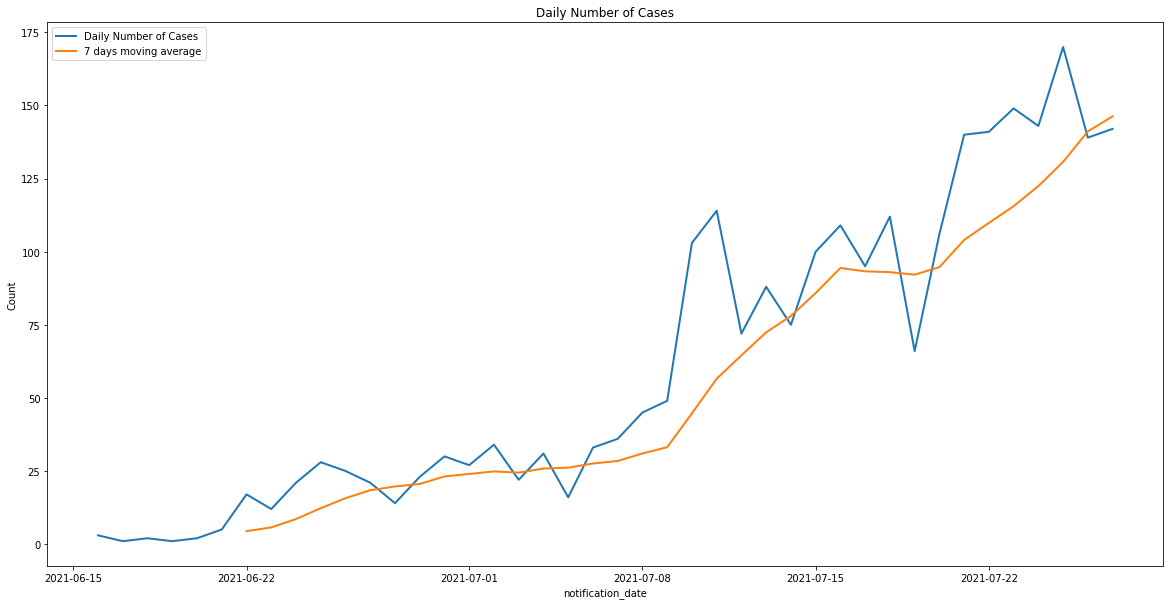

In [432]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="notification_date", y="Count", data=cases_agg, ax=ax, label="Daily Number of Cases", linewidth=2)
ax = sns.lineplot(x="notification_date", y="Weekly Rolling Average", data=cases_agg, ax=ax, label="7 days moving average", linewidth=2)
ax.set_title("Daily Number of Cases")

Text(0, 0.5, 'Cumulative Number of Cases')

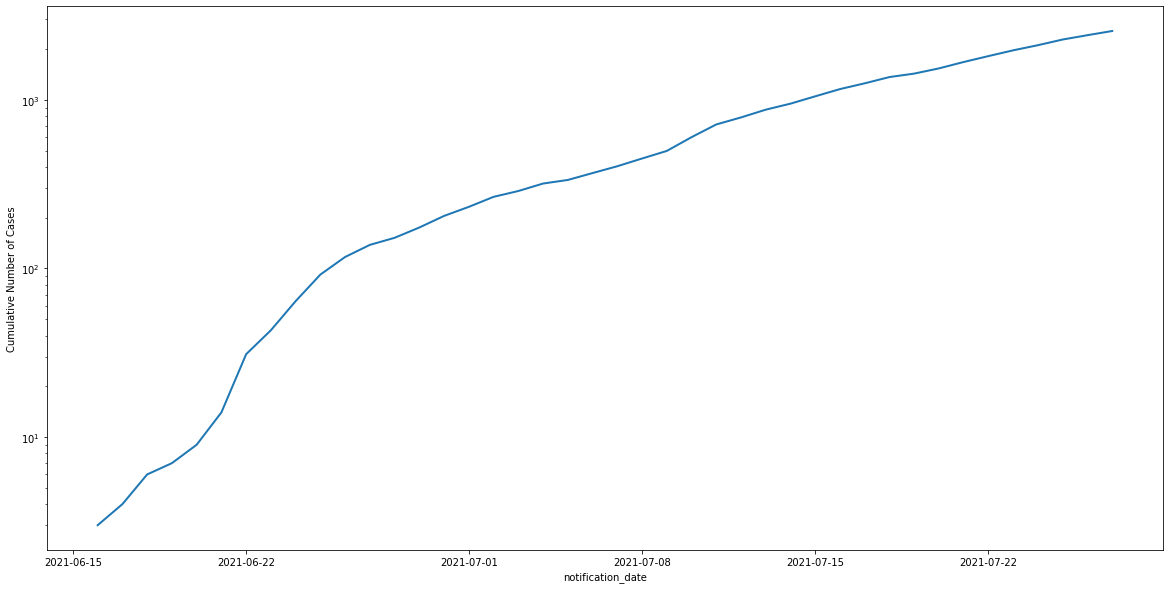

In [433]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="notification_date", y="Cumsum", data=cases_agg, ax=ax, linewidth=2)
ax.set_yscale("log")
ax.set_ylabel("Cumulative Number of Cases")

# Models

In [440]:
mask = cases_agg["Epidemiological Days"] >= 0
X = cases_agg.loc[mask, "Epidemiological Days"].values
y = cases_agg.loc[mask, "Count"].values

# Bayesian Model 

In [435]:
import pymc3 as pm

In [441]:
mask = cases_agg["Epidemiological Days"] >= 0

# Create PyMC3 context manager
with pm.Model() as model:
    t = pm.Data("x_data", X)
    cases = pm.Data("y_data", y)

    # Intercept - We fixed this at 100.
    a = pm.Normal("a", mu=100, sigma=10)

    # Slope - Growth rate: 0.2 is approx value reported by others
    b = pm.Normal("b", mu=0.2, sigma=0.5)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)

    trace = pm.sample()
    post_Pred = pm.sample_posterior_predictive(trace)

/tmp/ipykernel_779/2991526959.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.24884302808202513, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


/tmp/ipykernel_779/851248946.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


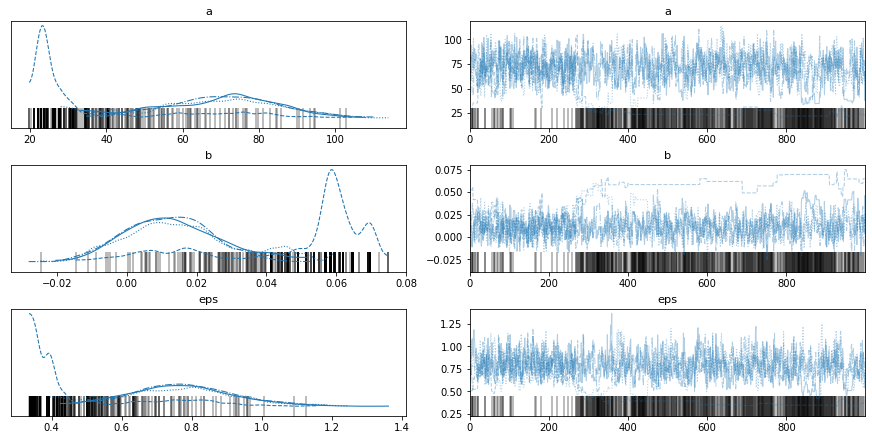

In [442]:
pm.traceplot(trace)
plt.show()

In [443]:
pm.summary(trace).round(2)

/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,60.53,22.58,22.06,92.55,7.81,5.73,9.0,12.0,1.35
b,0.02,0.02,-0.01,0.07,0.01,0.01,9.0,12.0,1.35
eps,0.69,0.20,0.34,0.99,0.07,0.05,9.0,12.0,1.38


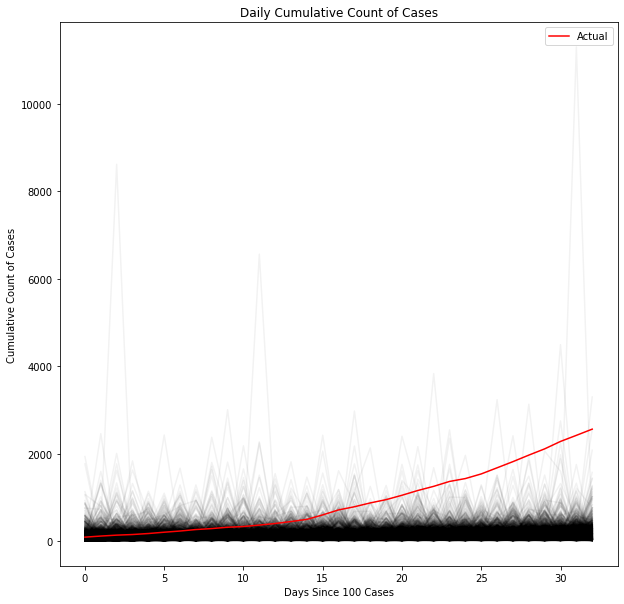

In [444]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(cases_agg.loc[mask, "Epidemiological Days"], post_Pred["cases"].T, color="k", alpha=0.05)
ax.plot(cases_agg.loc[mask, "Epidemiological Days"], cases_agg.loc[mask, "Cumsum"], color="r", label="Actual")
# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Cumulative Count of Cases", title="Daily Cumulative Count of Cases")
ax.legend()
# plt.show()

# Linear Model

In [383]:
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [384]:
model = PoissonRegressor()
model.fit(X_train.reshape(-1, 1), np.log(y_train))
y_pred = model.predict(X.reshape(-1, 1))
y_pred_test = model.predict(X_test.reshape(-1, 1))

R2: 0.9619358284694814
MSE: 0.02525657887699618


/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


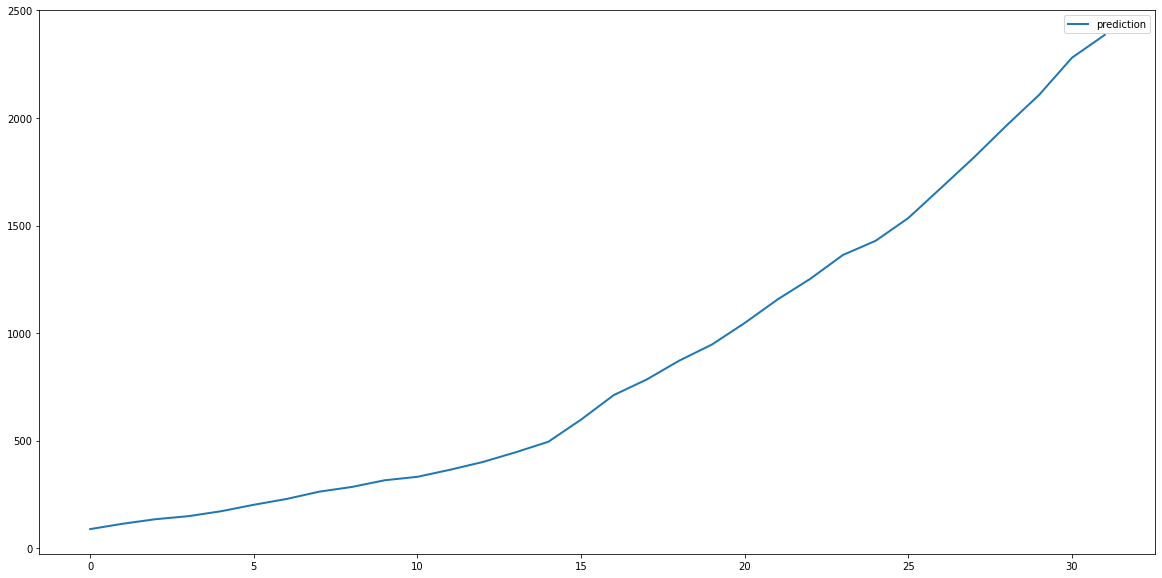

In [424]:
r2 = r2_score(np.log(y_test), y_pred_test)
print("R2:", r2)

mse = mean_squared_error(np.log(y_test), y_pred_test)
print("MSE:", mse)

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(X, y - np.exp(y_pred), ax=ax, label='prediction', linewidth=2)

In [386]:
from scipy import stats

def get_prediction_interval(y_true, y_pred, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction

    References:
        [1] https://towardsdatascience.com/prediction-intervals-in-linear-regression-2ea14d419981
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_true - y_pred)**2)
    stdev = np.sqrt(1 / (len(y_true) - 2) * sum_errs)
    
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    #generate prediction interval lower and upper bound
    lower, upper = y_pred - interval, y_pred + interval    
    
    return lower, upper

lower, upper = get_prediction_interval(np.log(y), y_pred)

/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/v

[Text(0, 0.5, 'Cumulative Number of Cases'),
 Text(0.5, 0, 'Days Since 100 Cases'),
 Text(0.5, 1.0, 'Estimation of Cumulative Number of Cases per Days Since 100 Cases')]

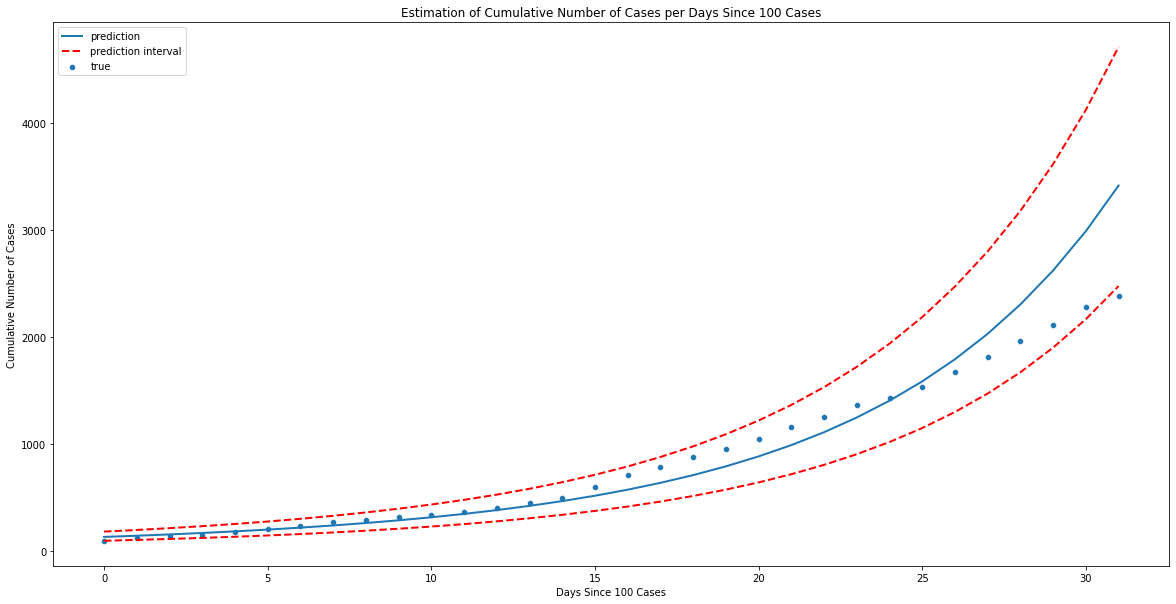

In [387]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(X, y, ax=ax, label='true')
ax = sns.lineplot(X, np.exp(y_pred), ax=ax, label='prediction', linewidth=2)
ax = sns.lineplot(X, np.exp(upper), ax=ax, linewidth=2, linestyle="--", color="r", label="prediction interval")
ax = sns.lineplot(X, np.exp(lower), ax=ax, linewidth=2, linestyle="--", color="r")
ax.set(ylabel="Cumulative Number of Cases", xlabel="Days Since 100 Cases", title="Estimation of Cumulative Number of Cases per Days Since 100 Cases")

## Stats Models

In [394]:
import statsmodels.api as sm
model = sm.GLM(np.log(y_train), X_train, family=sm.families.Poisson())
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:                            GLM   Df Residuals:                       23
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79.905
Date:                Wed, 28 Jul 2021   Deviance:                       71.371
Time:                        14:44:29   Pearson chi2:                     109.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0858      0.004     20.558      0.000       0.078       0.094
==============================================================================
"""

In [403]:
y_pred = model_results.predict(X)

/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

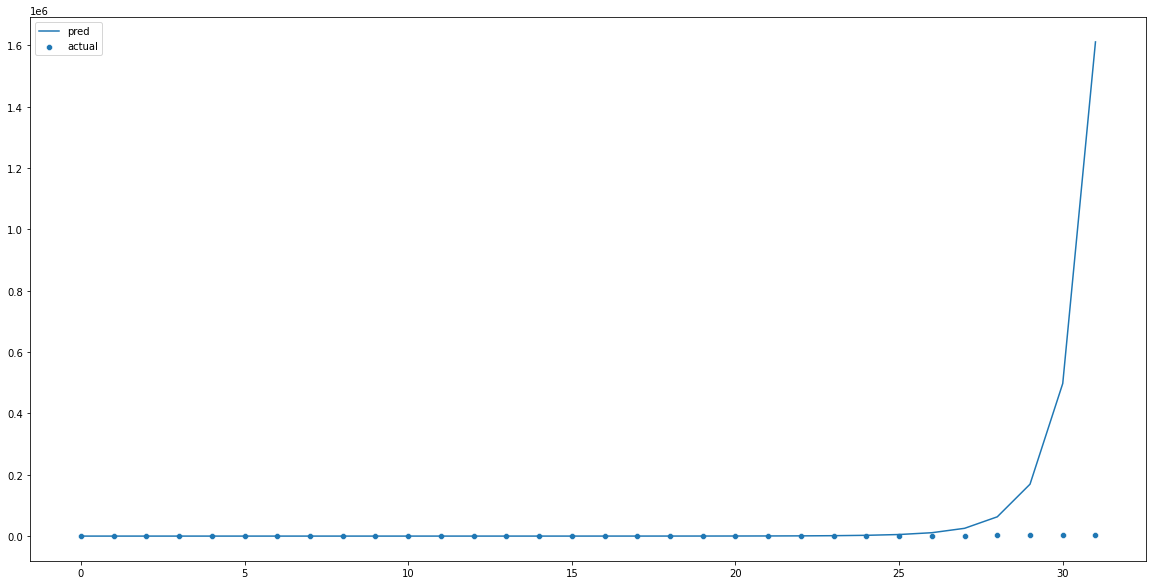

In [406]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(X, y, ax=ax, label='actual')
sns.lineplot(X, np.exp(y_pred), ax=ax, label='pred')

## Fit Logistic Curve

In [407]:
from scipy.optimize import curve_fit

def sigmoid(x, k, x0):

    return 1.0 / (1 + np.exp(-k * (x - x0)))

In [421]:
# Fit the curve
popt, pcov = curve_fit(sigmoid, X_train, y_train, method="trf")
estimated_k, estimated_x0 = popt
print(estimated_k)
print(estimated_x0)
print(pcov)

4.276945337505422
-3.9545969393750258
[[ 5.00023930e+18 -5.40782046e+18]
 [-5.40782046e+18  5.84862451e+18]]


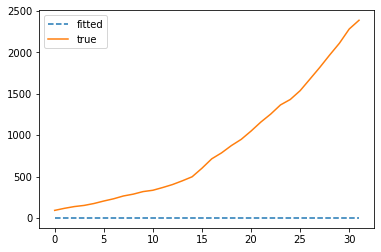

In [423]:
# Plot the fitted curve
y_pred = sigmoid(X, k=estimated_k, x0=estimated_x0)

# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X, y_pred, '--', label='fitted')
ax.plot(X, y, '-', label='true')


ax.legend()

# References

[1] https://www.architecture-performance.fr/ap_blog/fitting-a-logistic-curve-to-time-series-in-python/

[2] https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python